# feature set 1 chromosomes 2, 3, 4  + unknown

## In this notebook:

* single input dataframe 
* using feature set 1
* random forest
* only training/test split, no epochs 
* aucuracy assessement of RF:  0.67
* feature importance for RF (mostly just amino acid position)

In [5]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr2-4_unk_featureset5.pkl")



print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (40997, 9)
shape after dropping all data with score = '.' (40997, 9)
shape after dropping Unk (40997, 9)


aapos codonpos  Polyphen2_HVAR_pred     GenoCanyon_score  \
chr pos     ref alt                                                             
2   272223  G   A      102        1                    0    0.999999999999996   
                A       50        2                    0    0.999999999999996   
    277003  A   G      106        2                    1      0.9777236555582   
    1436306 C   A      135        2                   -2   0.0141758883741757   
    1436345 C   T      148        2                   -2  4.51595965165985E-4   

                    LINSIGHT     RVIS_ExAC     ExAC_cnv.score  \
chr pos     ref alt                                             
2   272223  G   A          0  -0.080196141  -1.38628707843331   
                A          0  -0.080196141  -1.38628707843331   
    277003  A   G          0  -0.080196141  -1.38628707843331   
    1436306 C   A          0   0.064587428  -2.47162789907313   
    1436345 C   T          0   0.064587428  -2.47162789907313   

                     SORVA_LOF_MAF0.005_HetOrHom  Problematic  
chr pos     ref alt                                            
2   272223  G   A                       0.000399            0  
                A                       0.000399            0  
    277003  A   G                       0.000399            2  
    1436306 C   A                       0.004792            0  
    1436345 C   T                       0.004792            0

In [6]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos codonpos  Polyphen2_HVAR_pred   GenoCanyon_score  \
chr pos       ref alt                                                           
2   231113819 T   C      155        1                    1  0.999999995135203   
    47476548  G   A      729        3                    0                1.0   
    178564725 C   G    25495        2                    0  0.826679312366365   

                      LINSIGHT     RVIS_ExAC      ExAC_cnv.score  \
chr pos       ref alt                                              
2   231113819 T   C          0   1.058222336   0.472051646986222   
    47476548  G   A          0  -1.024340829  -0.391627327762734   
    178564725 C   G          0   3.161811341                   0   

                       SORVA_LOF_MAF0.005_HetOrHom  Problematic  
chr pos       ref alt                                            
2   231113819 T   C                       0.001597            0  
    47476548  G   A              

Confusion matrix: 
 [[5868  643  245]
 [ 921 1464   33]
 [ 793   67  121]]
Accuracy: 0.7339241752831117
Recall TP/(TP+FN): [0.86856128 0.60545906 0.12334353]
Precision TP/(TP+FP): [0.77393827 0.67341306 0.30325815]
F1: [0.8185242  0.63763066 0.17536232]
Feature ranking:
1. feature 0 (0.348437)
aapos
2. feature 3 (0.189826)
GenoCanyon_score
3. feature 5 (0.140170)
RVIS_ExAC
4. feature 6 (0.115336)
ExAC_cnv.score
5. feature 2 (0.075275)
Polyphen2_HVAR_pred
6. feature 7 (0.055785)
SORVA_LOF_MAF0.005_HetOrHom
7. feature 1 (0.051574)
codonpos
8. feature 4 (0.023598)
LINSIGHT


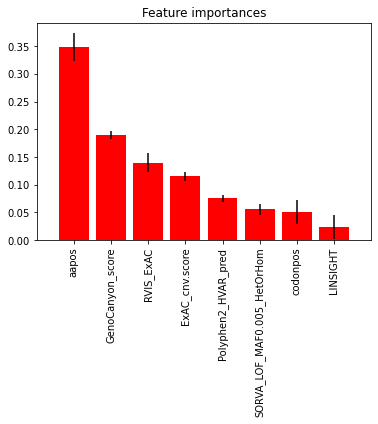

In [7]:
# Try a random forest:

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=1, class_weight="balanced")
#forest = RandomForestClassifier(n_estimators=10, random_state=42, class_weight="balanced")
forest.fit(df_train, train_labels)
#ax = plt.gca()
#rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
#svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
#plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()